### 02 Neural net

In [1]:
from init import *

2023-07-18 01:29:15.013659: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 01:29:15.019219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ss/gsl/gsl-2.7.1/.libs
2023-07-18 01:29:15.019252: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_path = ('data/train')
valid_path = ("data/valid")

Make a function to parse the data files

In [3]:
def one_hot_label(img):
    # img is the file name of a configuration
    category,T,_, = img.split('_')
    if category == 'low':
        ohl = np.array([1,0])
    elif category == 'high':
        ohl = np.array([0,1])
    return ohl,T
def data_with_label(path):
    data = []
    for filename in tqdm(os.listdir(path)):
        file_path = os.path.join(path, filename)
        file = np.load(file_path)
        data.append([file.astype(dtype='float32'), one_hot_label(filename)])
    shuffle(data)
    return data

In [4]:
train_set=data_with_label(train_path)
valid_set=data_with_label(valid_path)

100%|██████████| 6400/6400 [00:00<00:00, 7222.89it/s]


In [5]:
tr_img_data = np.array([i[0] for i in train_set])
tr_lbl_data = np.array([i[1][0] for i in train_set])
tr_Temp_data = np.array([i[1][1] for i in train_set])
val_img_data = np.array([i[0] for i in valid_set])
val_lbl_data = np.array([i[1][0] for i in valid_set])
val_Temp_data = np.array([float(i[1][1]) for i in valid_set])

Let's plot the data

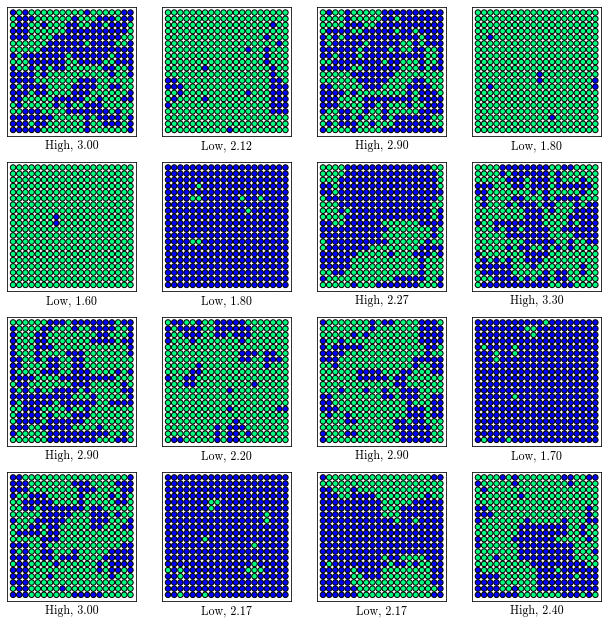

In [6]:
L=20
Rlist = np.array([m*np.array([1, 0]) + n*np.array([0, 1]) for m in range(L) for n in range(L)]) #create lattice
plt.figure(figsize=(10,10))
for i in range(16):
    #idx=bad_predictions[i]
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(tr_img_data[i], cmap='plasma')
    plt.scatter(Rlist[:,0], Rlist[:,1], s=30, ec='k', c=tr_img_data[i], cmap='winter') #plot lattice and spins
    if tr_lbl_data[i][0] == 1:
        label = "Low"
    elif tr_lbl_data[i][1] == 1:
        label = "High"
    plt.xlabel(f'{label}, {tr_Temp_data[i]}')
    

### Build the neural network model
Here, I create a NN model that consists of 100 hidden layer with a sigmoid function. The output layer contains two unit with softmax activation function.

In [7]:
model1 = keras.Sequential([
        keras.layers.Flatten(input_shape=(20, 20)),
        keras.layers.Dense(100, activation=tf.nn.sigmoid),
        keras.layers.Dense(2, activation=tf.nn.softmax)
])

2023-07-18 01:30:04.313736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 01:30:04.314115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ss/gsl/gsl-2.7.1/.libs
2023-07-18 01:30:04.314149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ss/gsl/gsl-2.7.1/.libs
2023-07-18 01:30:04.314183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory;

In [8]:
model1.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

In [9]:
history = model1.fit(x=tr_img_data,
                    y=tr_lbl_data, 
                    epochs=20,
                    batch_size=128)

Epoch 1/20
125/125 [==============================] - 1s 2ms/step - loss: 0.6948 - accuracy: 0.5319
Epoch 2/20
125/125 [==============================] - 0s 3ms/step - loss: 0.6443 - accuracy: 0.6115
Epoch 3/20
125/125 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.7237
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.5076 - accuracy: 0.8352
Epoch 5/20
125/125 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.8967
Epoch 6/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.9001
Epoch 7/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.9082
Epoch 8/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2698 - accuracy: 0.9136
Epoch 9/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.9168
Epoch 10/20
125/125 [==============================] - 0s 2ms/step - loss: 0.2268 - accuracy: 0.9201

Plot accuracy vs. no. of epochs

Text(0, 0.5, 'Accuracy')

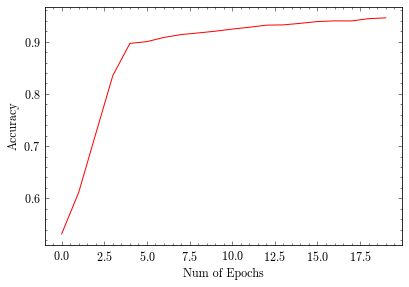

In [10]:
plt.plot(history.history['accuracy'],'r')
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")

In [11]:
val_loss, val_acc = model1.evaluate(val_img_data, val_lbl_data,)
print('Validation accuracy:', val_acc)
print('Validation loss:', val_loss)

200/200 [==============================] - 0s 765us/step - loss: 0.2126 - accuracy: 0.9136
Validation accuracy: 0.9135937690734863
Validation loss: 0.21257664263248444


### Determination of the critical temperature
First get the model predictions for the validation set, and separate the outputs for the two neurons in the final layer.

In [12]:
predictions=model1.predict(val_img_data)

low_predict = predictions[:,0]
high_predict = predictions[:,1]

200/200 [==============================] - 0s 626us/step


Combine the temperature of the simulations with their predicted phase.

In [13]:
df1 = pd.DataFrame({'low_prediction':low_predict,'High_prediction':high_predict, 'Temp':val_Temp_data})
df1.head()

,low_prediction,High_prediction,Temp
0,0.711928,0.288072,2.27
1,0.002627,0.997373,2.60
2,0.004467,0.995533,2.42
3,0.013288,0.986712,3.40
4,0.027572,0.972428,2.30


Determine the average (and standard deviation) output of both neurons in the output layer. Then, plot these averages against the Temperature.

In [14]:
df2=df1.groupby('Temp').mean()
df3=df1.groupby('Temp').std()

Cross-over temperature is close to the theoretical value $T_c = 2.27$

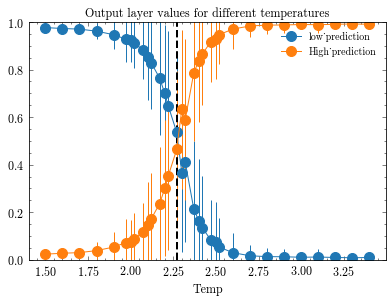

In [15]:
df2.plot(marker='o',yerr=df3, title="Output layer values for different temperatures")
plt.ylim([0,1])
plt.axvline(2.27, c='black', linestyle ='--',lw=2)

###  Convolutional Neural Net
Now I construct a neural net with two hidden layers. To proceed, one needs to incorporate periodic boundary conditions (PBC), which can be done by adding 2x2 padding on each side.   

In [16]:
def periodic_padding(image, padding=1):
    '''
    Create a periodic padding for an image, to emulate periodic boundary conditions in the simulations.
    '''
    upper_pad = image[-padding:,:]
    lower_pad = image[:padding,:]
    
    partial_image = np.concatenate([upper_pad, image, lower_pad], axis=0)
    
    left_pad = partial_image[:,-padding:]
    right_pad = partial_image[:,:padding]
    
    padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=1)
    
    return padded_image

Text(0.5, 1.0, 'With padding (periodic)')

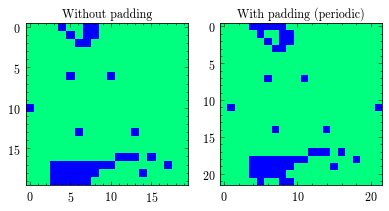

In [18]:
plt.subplot(1,2,1)
plt.imshow(tr_img_data[1], cmap='winter')
plt.title("Without padding")
plt.subplot(1,2,2)
plt.imshow(periodic_padding(tr_img_data[1]), cmap='winter')
plt.title("With padding (periodic)")

Rehsape to feed it into CNN

In [19]:
tr_img_data = np.array([periodic_padding(i[0]) for i in train_set]).reshape(-1,22,22,1)
val_img_data = np.array([periodic_padding(i[0]) for i in valid_set]).reshape(-1,22,22,1)

Define the CNN model

In [20]:
model2 = keras.Sequential([
    keras.layers.Conv2D(64, (2, 2), input_shape=(22, 22, 1), padding='valid'),
    keras.layers.ReLU(),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [21]:
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history2 = model2.fit(x=tr_img_data,y=tr_lbl_data, epochs=20,batch_size=128)

Epoch 1/20
125/125 [==============================] - 4s 33ms/step - loss: 0.2142 - accuracy: 0.9131
Epoch 2/20
125/125 [==============================] - 4s 31ms/step - loss: 0.1590 - accuracy: 0.9336
Epoch 3/20
125/125 [==============================] - 4s 29ms/step - loss: 0.1509 - accuracy: 0.9364
Epoch 4/20
125/125 [==============================] - 3s 28ms/step - loss: 0.1374 - accuracy: 0.9434
Epoch 5/20
125/125 [==============================] - 3s 28ms/step - loss: 0.1315 - accuracy: 0.9444
Epoch 6/20
125/125 [==============================] - 3s 28ms/step - loss: 0.1241 - accuracy: 0.9486
Epoch 7/20
125/125 [==============================] - 3s 27ms/step - loss: 0.1196 - accuracy: 0.9511
Epoch 8/20
125/125 [==============================] - 4s 28ms/step - loss: 0.1114 - accuracy: 0.9546
Epoch 9/20
125/125 [==============================] - 3s 28ms/step - loss: 0.1069 - accuracy: 0.9552
Epoch 10/20
125/125 [==============================] - 3s 28ms/step - loss: 0.1030 - accura

Text(0, 0.5, 'Accuracy')

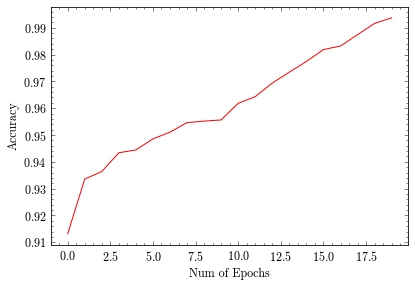

In [23]:
plt.plot(history2.history['accuracy'],'r')
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")

In [24]:
val_loss, val_acc = model2.evaluate(val_img_data, val_lbl_data)
print('Test accuracy:', val_acc)
print('Validation loss:', val_loss)

200/200 [==============================] - 1s 4ms/step - loss: 0.3085 - accuracy: 0.9161
Test accuracy: 0.9160937666893005
Validation loss: 0.3085496723651886


We perform a similar process again

In [25]:
predictions2=model2.predict(val_img_data)

low_predict2 = predictions2[:,0]
high_predict2 = predictions2[:,1]

200/200 [==============================] - 1s 6ms/step


In [26]:
df4 = pd.DataFrame({'low_prediction':low_predict2,'high_prediction':high_predict2, 'Temp':val_Temp_data})

Similar to before, the cross-over temperature is very close to theoretical value $T_c=2.27$

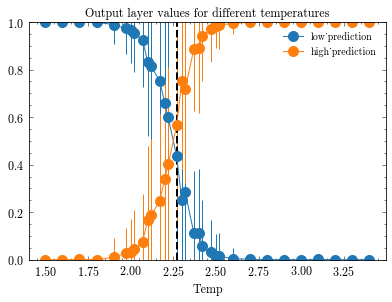

In [27]:
df5=df4.groupby('Temp').mean()
df6=df4.groupby('Temp').std()
df5.plot(marker='o',yerr=df6,title="Output layer values for different temperatures")
plt.ylim([0,1])
plt.axvline(2.27,c='black', linestyle ='--',lw=2)